In [495]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy.stats import f_oneway

In [473]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [474]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [475]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [476]:
total = df_train.isnull().sum()
percentage = (df_train.isnull().sum()/df_train.isnull().count() *100)
dtype = df_train.dtypes
nulls = pd.concat([total,percentage,dtype],axis = 1, keys=["Total", 'Percentage','Type']).sort_values(['Total'], ascending=False)
display(nulls)

,Total,Percentage,Type
PoolQC,1453,99.520548,object
MiscFeature,1406,96.301370,object
Alley,1369,93.767123,object
Fence,1179,80.753425,object
FireplaceQu,690,47.260274,object
LotFrontage,259,17.739726,float64
GarageYrBlt,81,5.547945,float64
GarageCond,81,5.547945,object
GarageType,81,5.547945,object
GarageFinish,81,5.547945,object


In [477]:
drop_columns_list = [i for i in nulls.index if nulls.loc[i, 'Percentage'] >= 50]
print(drop_columns_list)
df_train = df_train.drop(drop_columns_list, axis = 1)
df_test = df_test.drop(drop_columns_list, axis = 1)
nulls = nulls.drop(drop_columns_list, axis=0)

['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [478]:
null_obj_list = [i for i in nulls.index if nulls.loc[i, 'Total'] != 0 and nulls.loc[i, 'Type'] == 'object']

for col in null_obj_list:
    df_train[col].fillna(value="None", inplace = True)
    df_test[col].fillna(value="None", inplace = True)

In [479]:
total = df_train.isnull().sum()
percentage = (df_train.isnull().sum()/df_train.isnull().count() *100)
dtype = df_train.dtypes
pd.concat([total,percentage,dtype],axis = 1, keys=["Total", 'Percentage','Type']).sort_values(['Total'], ascending=False).head()

,Total,Percentage,Type
LotFrontage,259,17.739726,float64
GarageYrBlt,81,5.547945,float64
MasVnrArea,8,0.547945,float64
Id,0,0.000000,int64
BedroomAbvGr,0,0.000000,int64


In [480]:
df_train.fillna(value=df_train.median(), inplace = True)
df_test.fillna(value=df_test.median(), inplace = True)

total = df_train.isnull().sum()
percentage = (df_train.isnull().sum()/df_train.isnull().count() *100)
dtype = df_train.dtypes
pd.concat([total,percentage,dtype],axis = 1, keys=["Total", 'Percentage','Type']).sort_values(['Total'], ascending=False).head()

,Total,Percentage,Type
Id,0,0.0,int64
HalfBath,0,0.0,int64
FireplaceQu,0,0.0,object
Fireplaces,0,0.0,int64
Functional,0,0.0,object


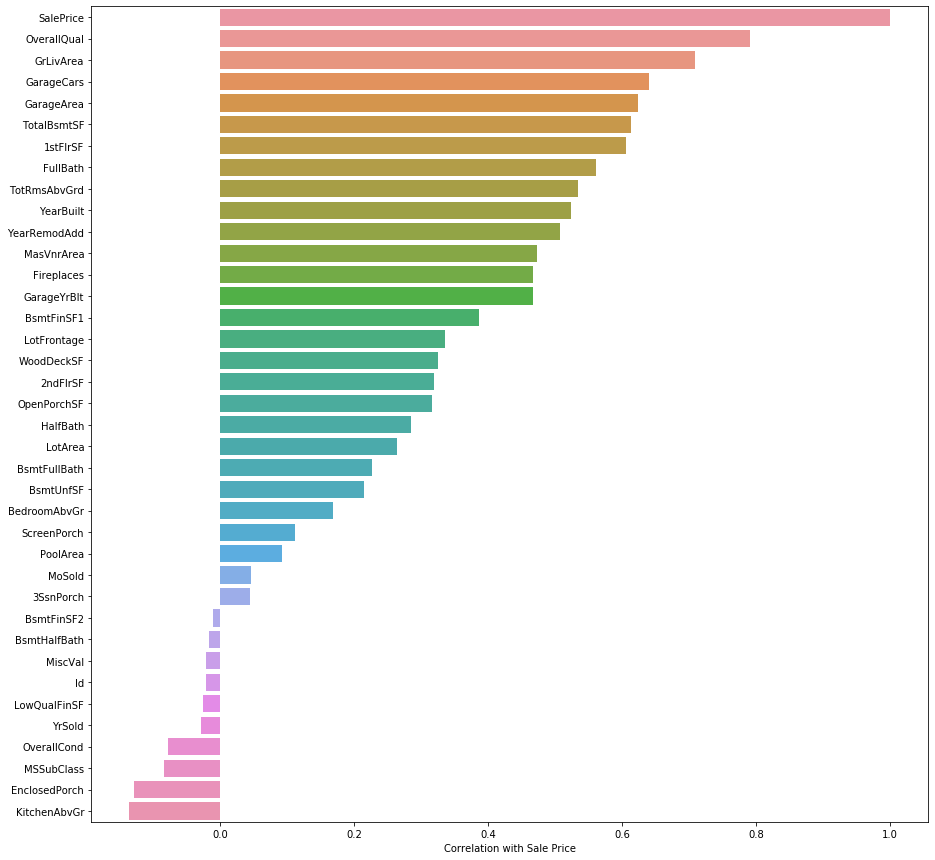

In [481]:
corr_matrix = df_train.corr()
corr_matrix = corr_matrix['SalePrice'].sort_values(ascending=False)

plt.figure(figsize=[15,15])
sns.barplot(y = corr_matrix.index, x = corr_matrix)
plt.xlabel('Correlation with Sale Price')
plt.show()

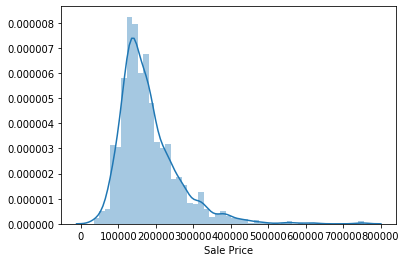

In [482]:
sns.distplot(df_train['SalePrice'], axlabel='Sale Price');

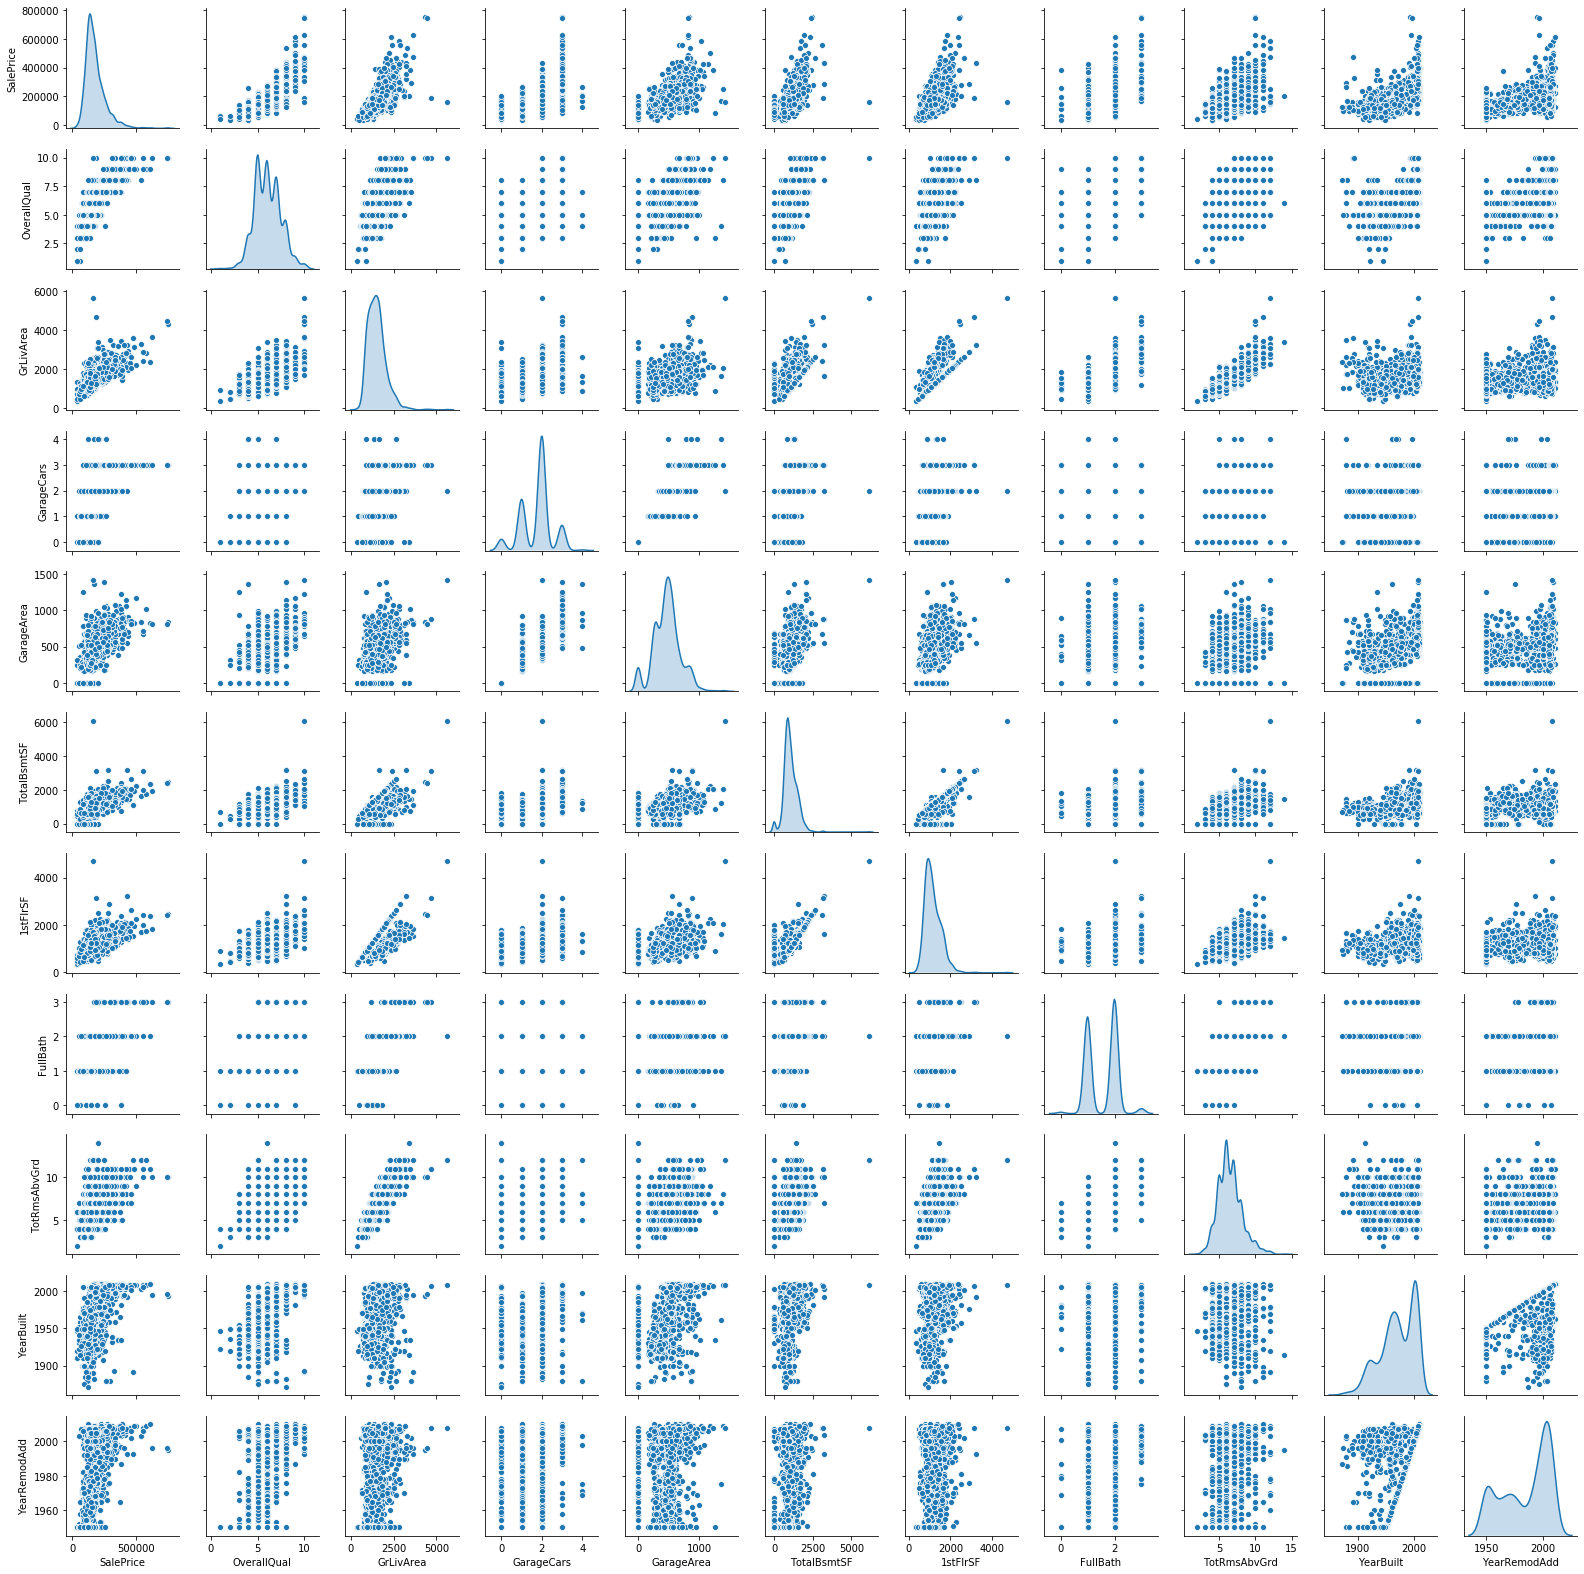

In [483]:
attributes = [i for i in corr_matrix.index if corr_matrix.loc[i] >= 0.5]
sns.pairplot(df_train[attributes], height = 2, kind = 'scatter', diag_kind = 'kde')
plt.show()

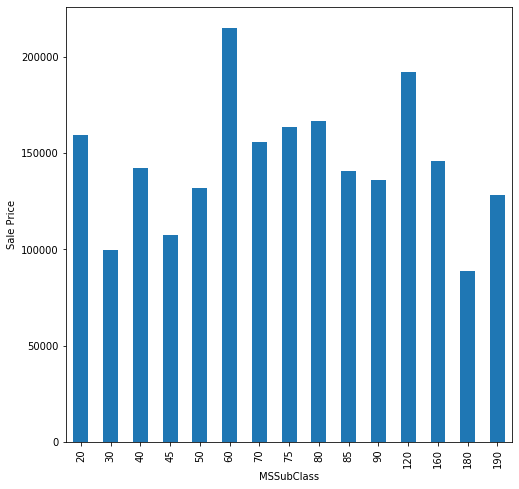

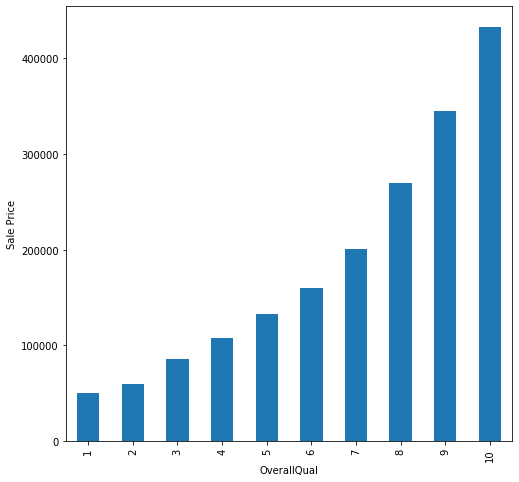

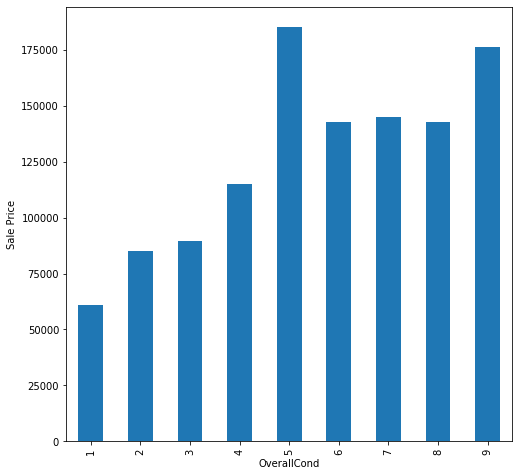

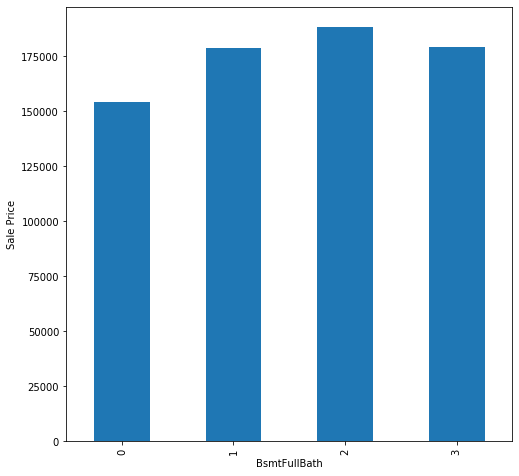

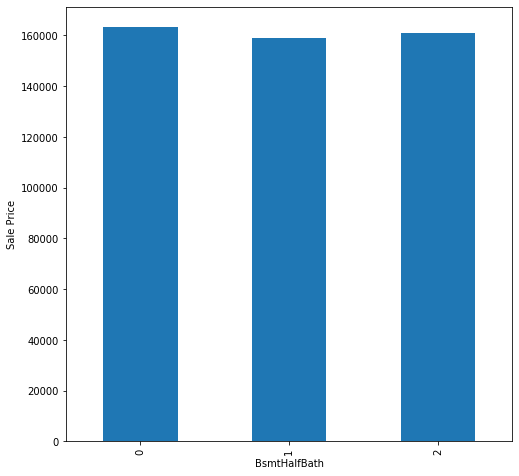

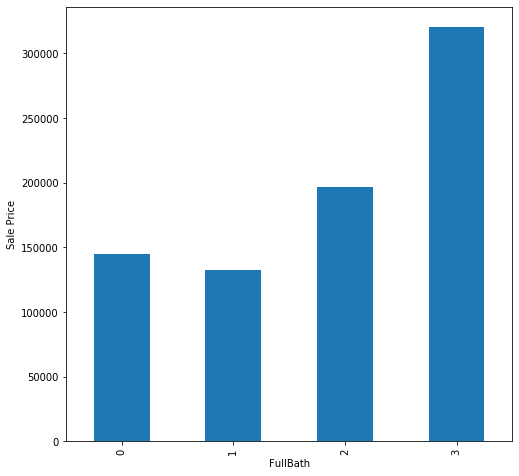

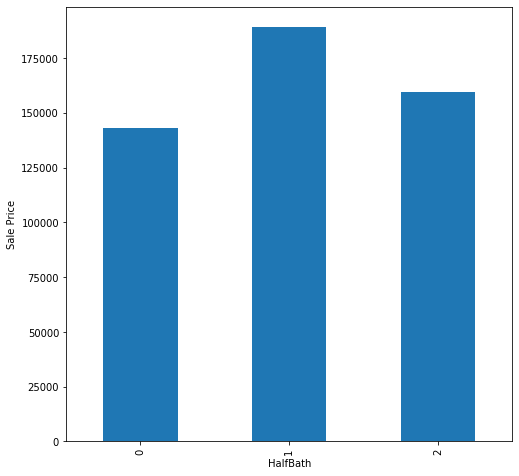

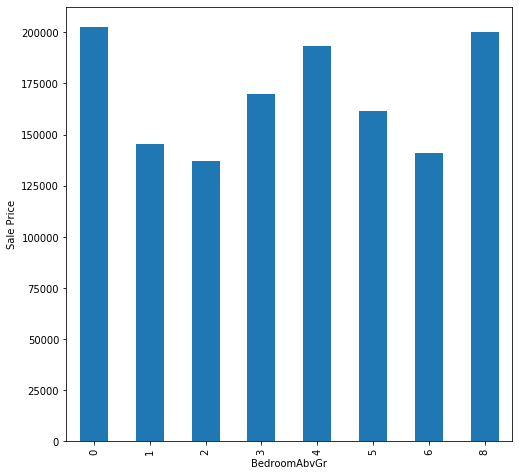

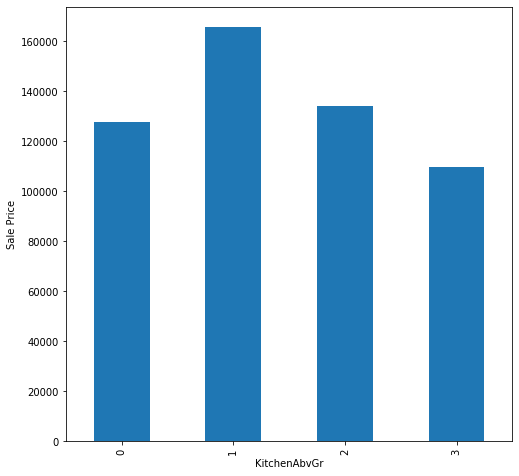

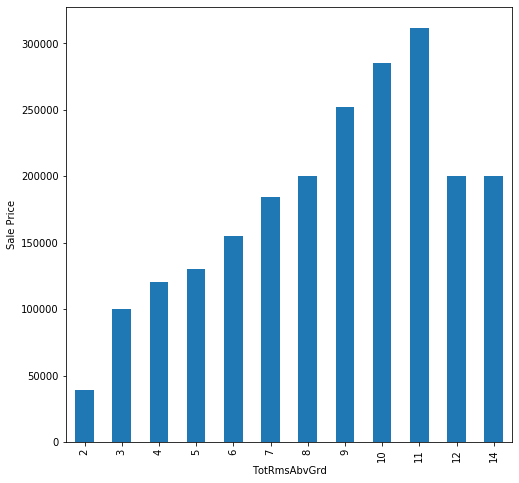

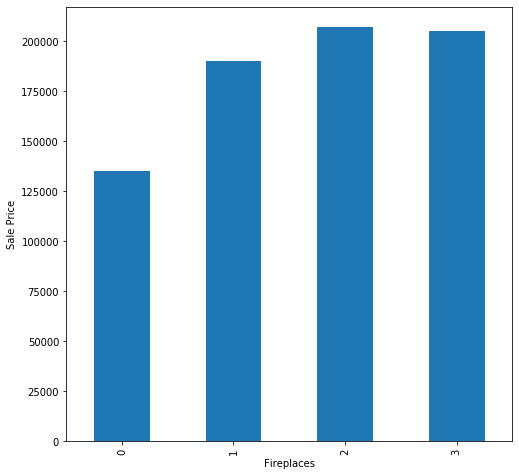

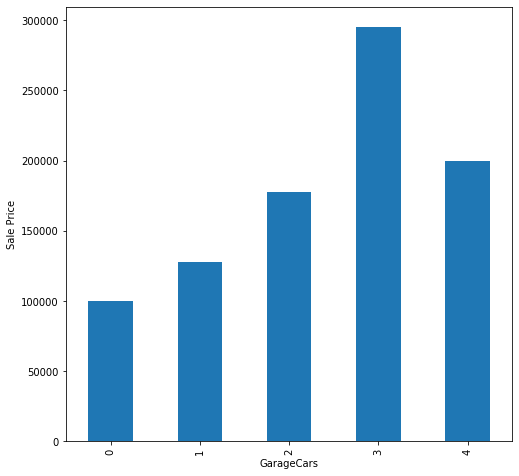

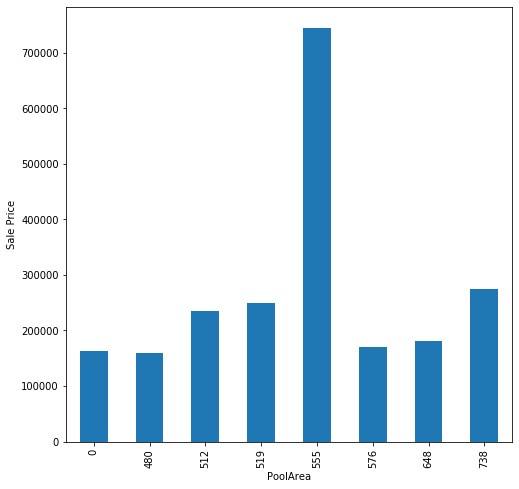

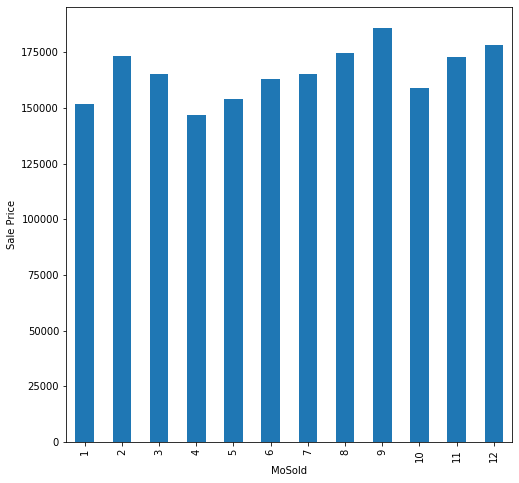

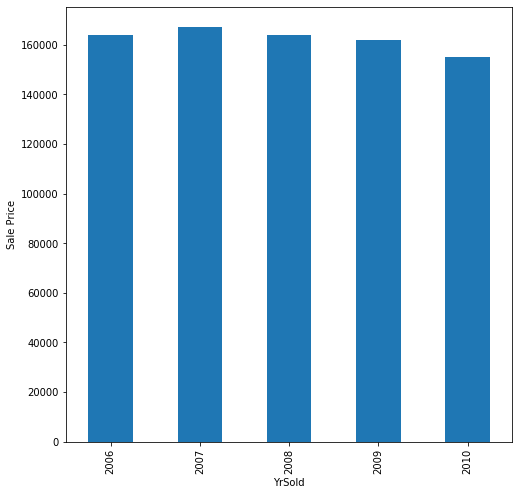

In [413]:
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index
numerical_features = df_train.dtypes[df_train.dtypes != "object"].index.drop('Id')
discrete_features = [feature for feature in numerical_features if len(df_train[feature].unique()) < 20 ]
continuous_features = [i for i in attributes if i not in discrete_features]

for feature in discrete_features:
    plt.figure(figsize=[8,8])
    df_train.groupby(feature)['SalePrice'].median().plot.bar()
#     plt.bar(df_train[feature], df_train['SalePrice'])
    plt.xlabel(feature)
    plt.ylabel('Sale Price')
    plt.show()

In [484]:
categorical_features

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

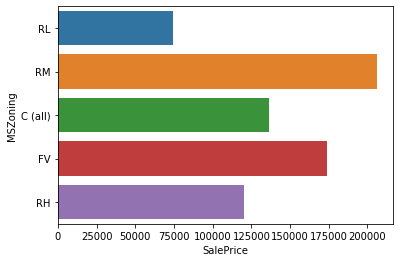

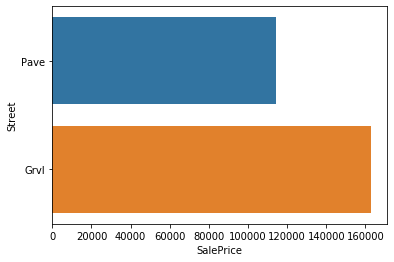

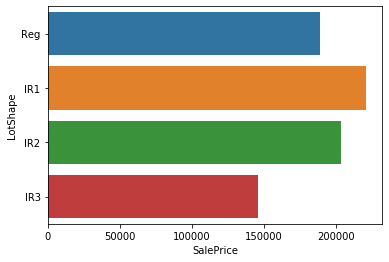

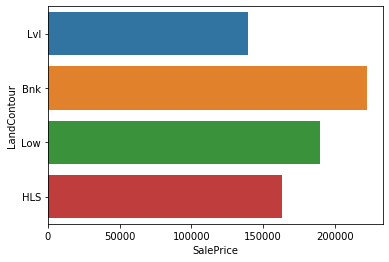

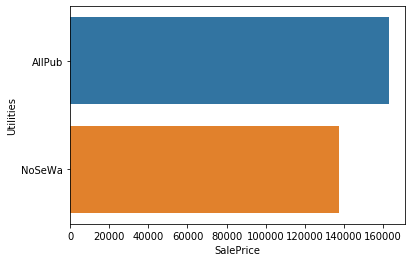

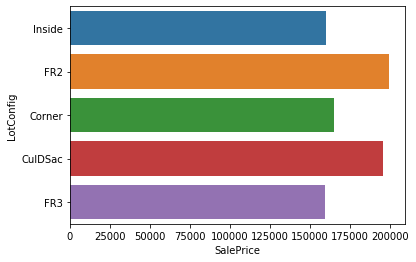

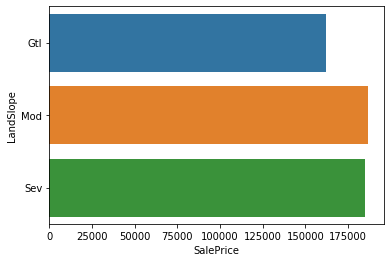

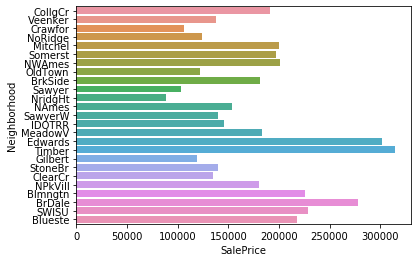

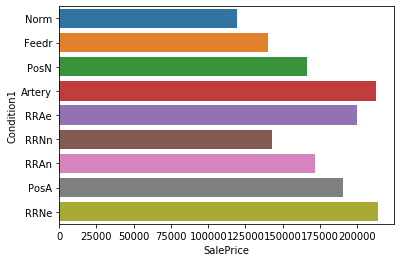

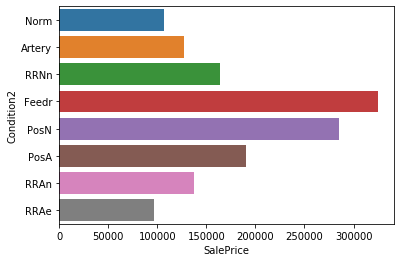

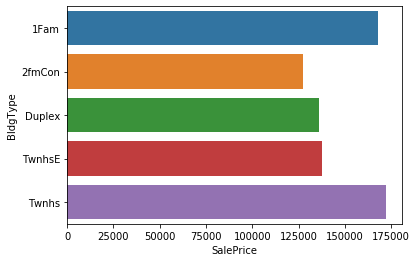

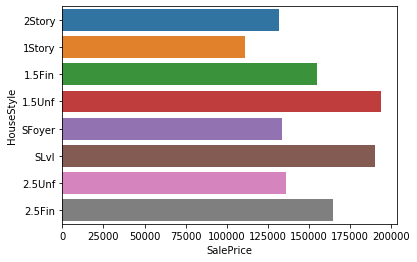

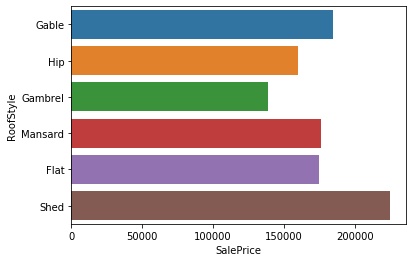

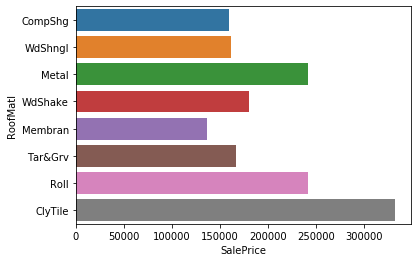

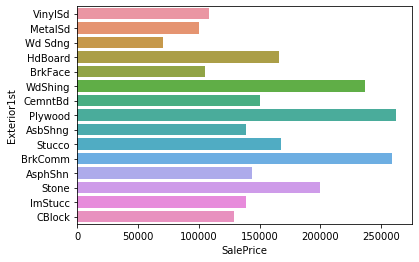

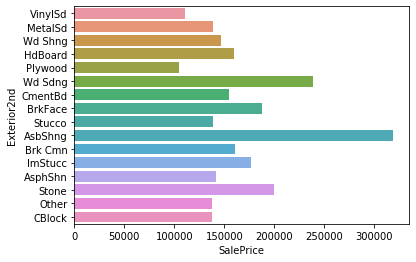

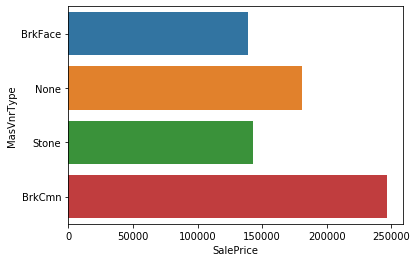

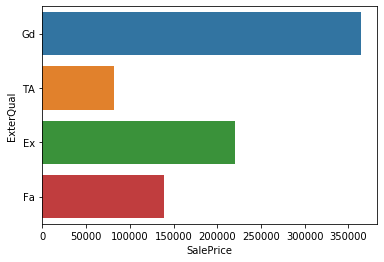

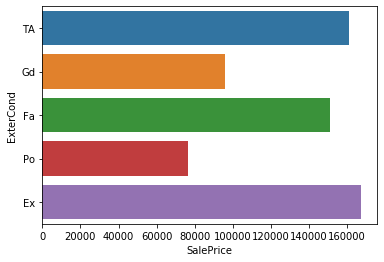

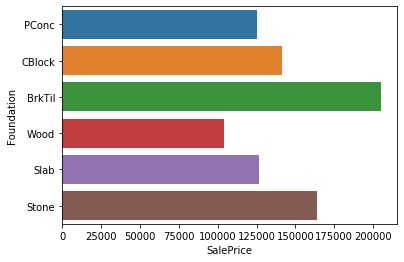

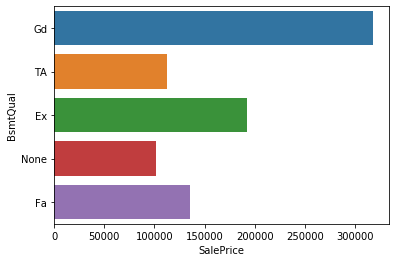

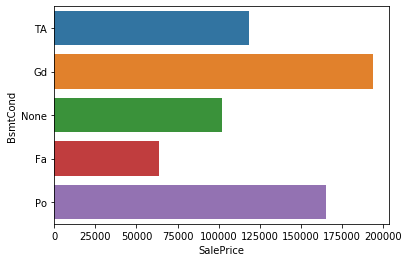

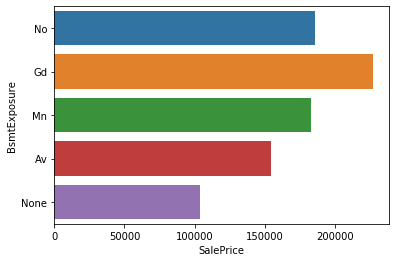

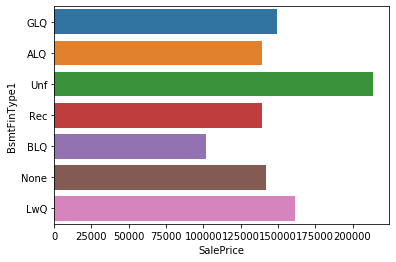

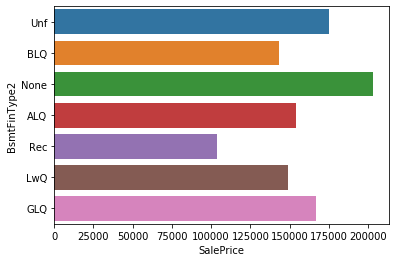

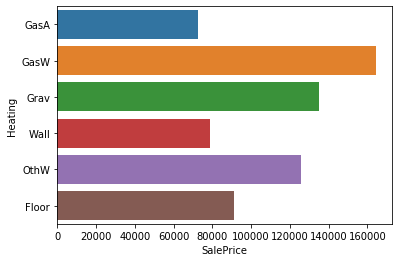

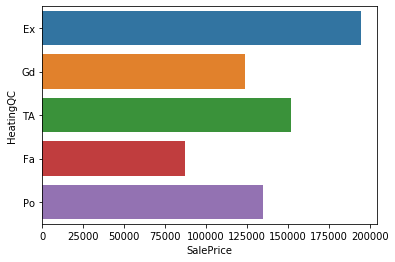

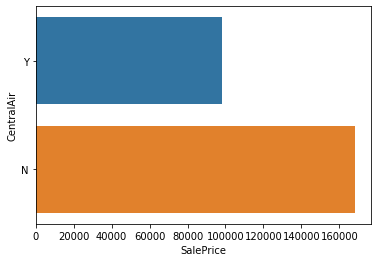

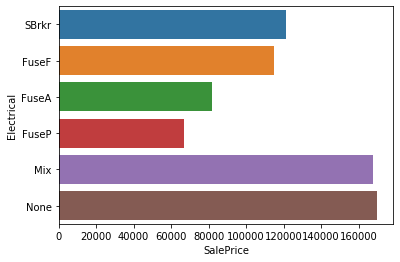

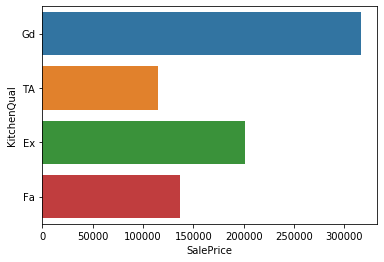

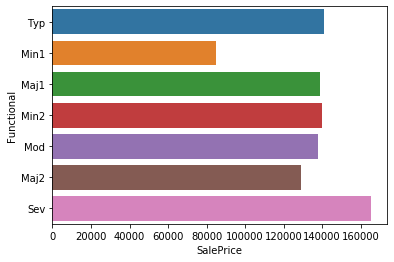

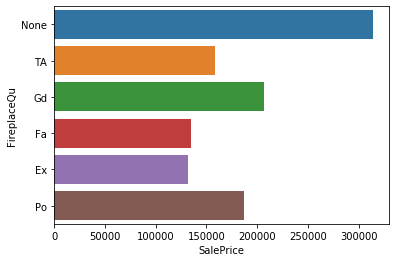

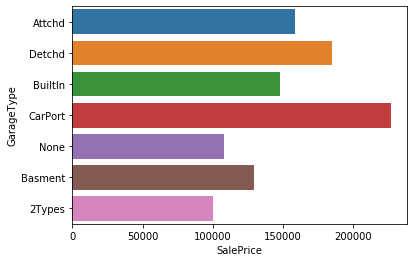

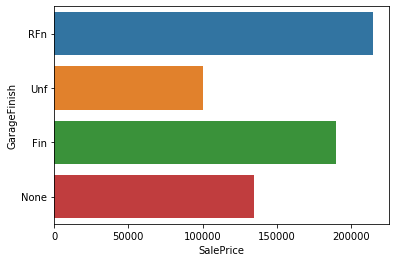

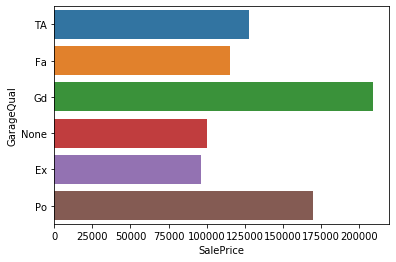

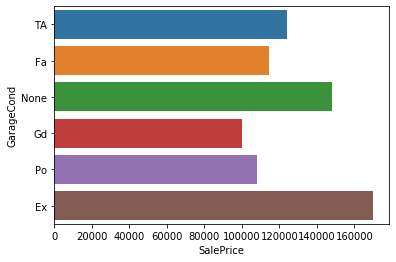

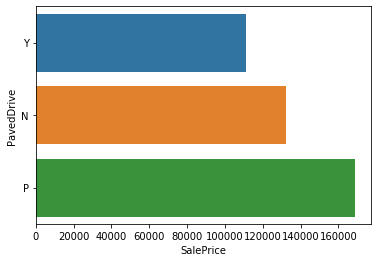

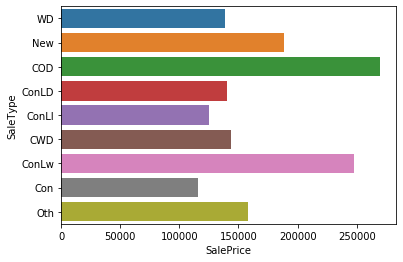

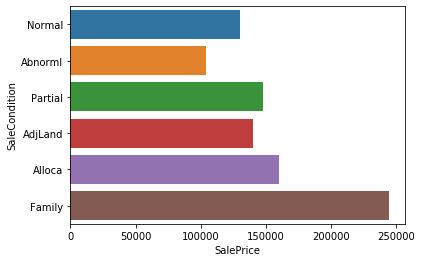

In [417]:
for feature in categorical_features:
    sns.barplot(y=df_train[feature].unique(), x= df_train.groupby(feature)['SalePrice'].median())
    plt.ylabel(feature)
    plt.show()
#     print(df_train[feature].unique())
#     print(df_train.groupby(feature)['SalePrice'].median())

In [522]:
# p = f_oneway(df_train['SalePrice'].loc[df_train['SaleCondition'] == 'Normal'],
#                df_train['SalePrice'].loc[df_train['SaleCondition'] == 'Abnormal'],
#                df_train['SalePrice'].loc[df_train['SaleCondition'] == 'Partial'],
#                df_train['SalePrice'].loc[df_train['SaleCondition'] == 'AdjLand'],
#                df_train['SalePrice'].loc[df_train['SaleCondition'] == 'Alloca'],
#                df_train['SalePrice'].loc[df_train['SaleCondition'] == 'Family'])

F = f_oneway(df_train['SalePrice'].loc[df_train['Street'] == 'Pave'],
             df_train['SalePrice'].loc[df_train['Street'] == 'Grvl'])

# display(df_train['SalePrice'].loc[df_train['SaleCondition'] == 'Normal'])
# display(pd.DataFrame(df_train['SalePrice'].loc[df_train['SaleCondition'] == 'Normal']))
F

F_onewayResult(statistic=2.4592895583691994, pvalue=0.11704860406782483)

In [217]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [264]:
Q1 = df_train.quantile(0.25)
Q3 = df_train.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df_train < (Q1 - 1.5 * IQR)) | (df_train > (Q3 + 1.5 * IQR))).sum()
outlier_percentage = outliers/(df_train).count() * 100
pd.set_option('display.max_rows', 500)

display(pd.concat([Q1,Q3,IQR,outliers,outlier_percentage],axis = 1, keys=['Q1','Q3','IQR','outliers','outlier_percentage'],join='inner'))

,Q1,Q3,IQR,outliers,outlier_percentage
Id,365.75,1095.25,729.50,0,0.000000
MSSubClass,20.00,70.00,50.00,103,7.054795
LotFrontage,60.00,79.00,19.00,106,7.260274
LotArea,7553.50,11601.50,4048.00,69,4.726027
OverallQual,5.00,7.00,2.00,2,0.136986
OverallCond,5.00,6.00,1.00,125,8.561644
YearBuilt,1954.00,2000.00,46.00,7,0.479452
YearRemodAdd,1967.00,2004.00,37.00,0,0.000000
MasVnrArea,0.00,164.25,164.25,98,6.712329
BsmtFinSF1,0.00,712.25,712.25,7,0.479452


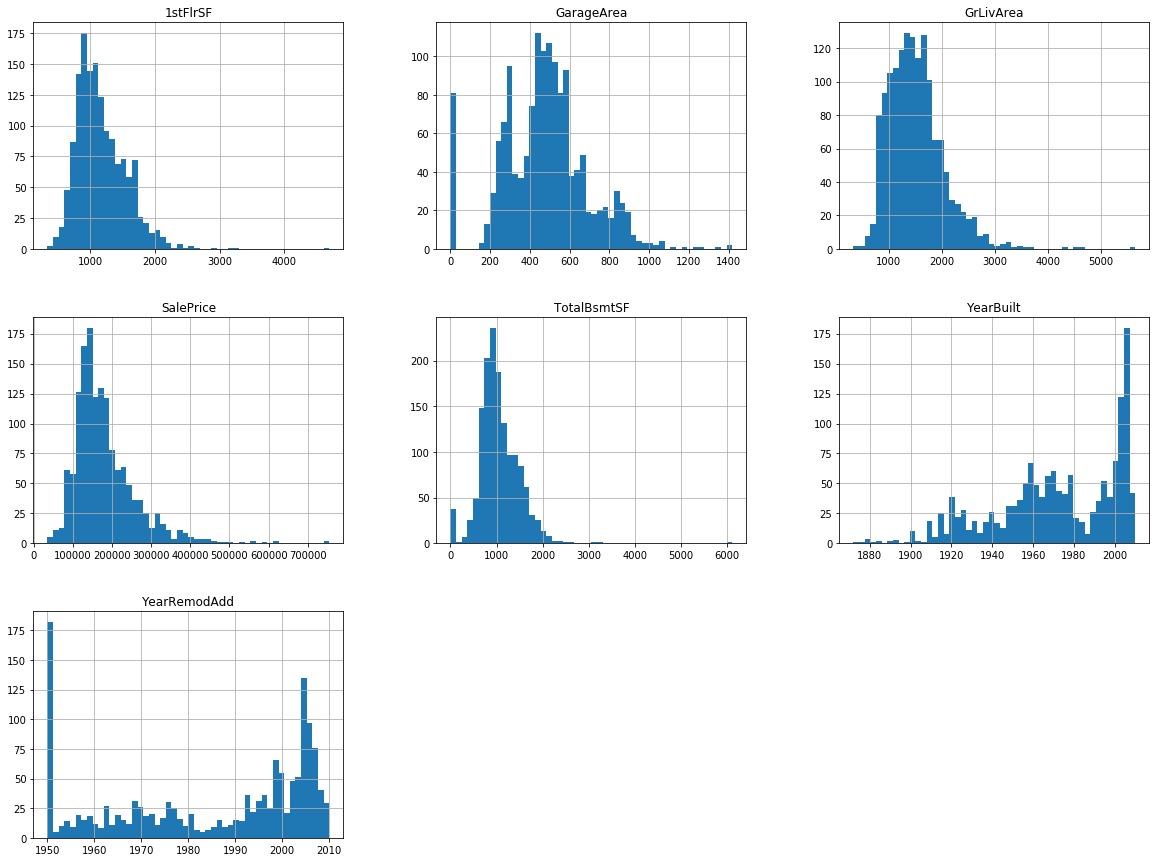

In [355]:
df_train[continuous_features].hist(bins=50, figsize=(20,15))
plt.show()

In [101]:
corr_matrix = df_train.corr()
corr_matrix = corr_matrix['SalePrice'].sort_values(ascending=False)
print(corr_matrix)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

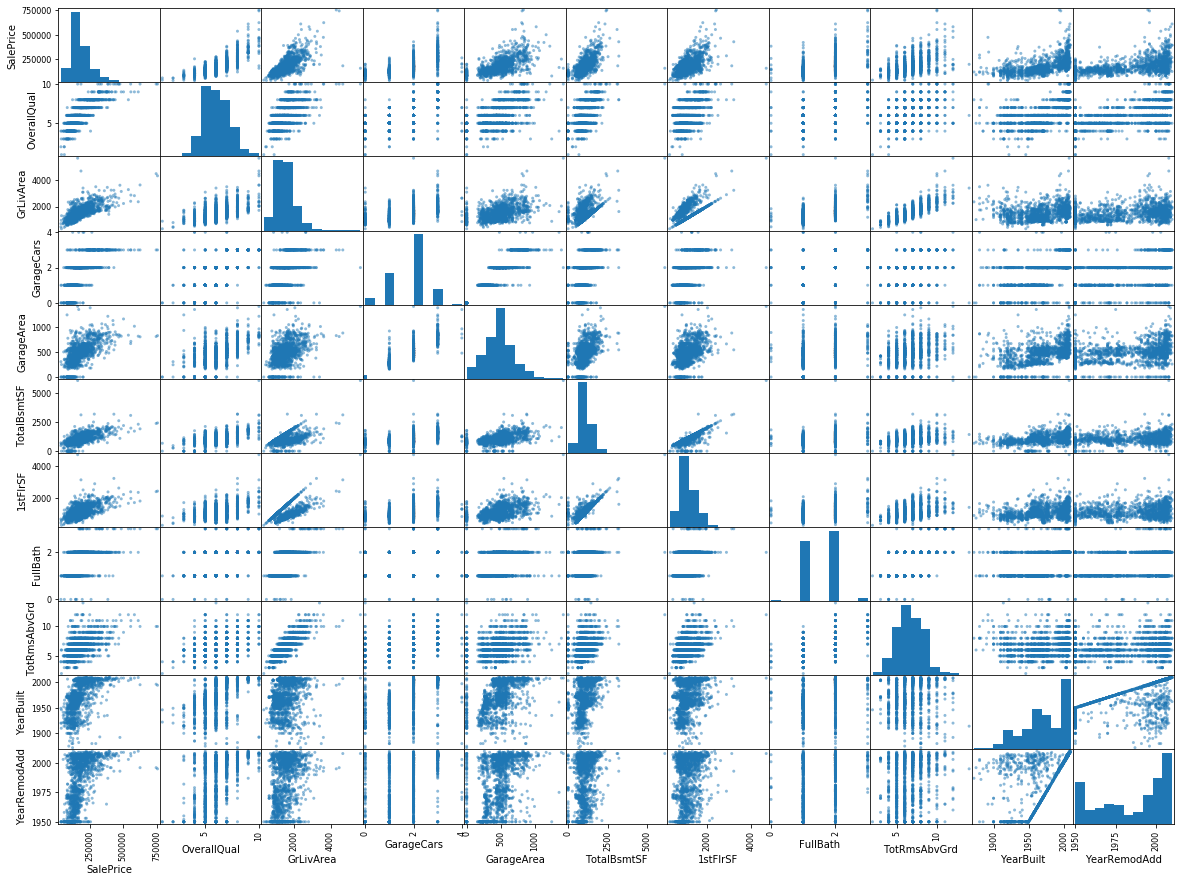

In [118]:
attributes = [i for i in corr_matrix.index if corr_matrix.loc[i] >= 0.5]
attributes
scatter_matrix(df_train[attributes], figsize=(20, 15))
plt.show()

In [116]:
df_train['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)